1. 데이터 수집 및 탐색: diamonds 데이터셋 로드
데이터셋의 크기: (53940, 10)
--------------------------------------------------
2. 파이프라인 구축: StackingRegressor 모델 포함
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('regressor',
                 StackingRegressor(cv=3,
                                   estimators=[('lgbm',
                                                LGBMRegre

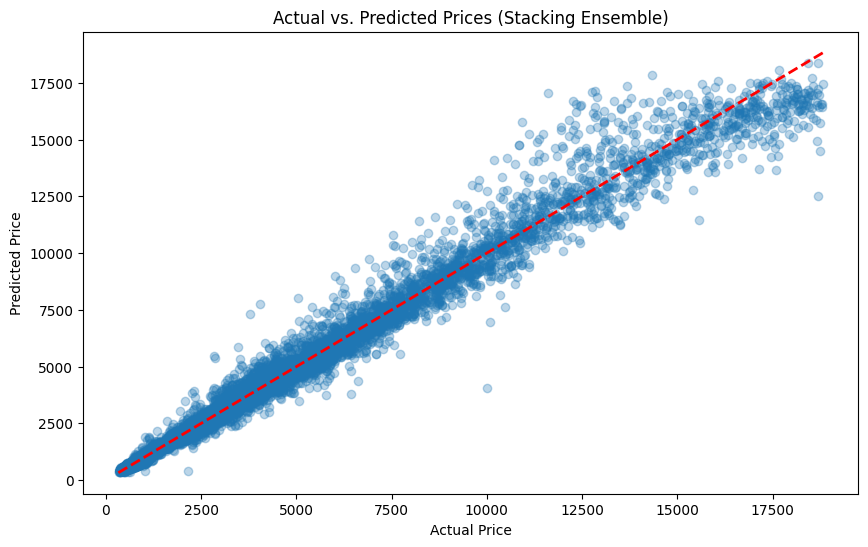

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 및 전처리에 필요한 라이브러리들을 불러옵니다.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# 앙상블 기법 중 StackingRegressor를 사용합니다.
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# 사용할 부스팅 모델들을 불러옵니다.
# LightGBM
import lightgbm as lgb
# XGBoost
import xgboost as xgb
# CatBoost (설치가 필요할 수 있습니다: pip install catboost)
from catboost import CatBoostRegressor

# 경고 메시지를 무시합니다.
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 수집 및 탐색
# seaborn 라이브러리의 diamonds 데이터셋을 불러옵니다.
print("1. 데이터 수집 및 탐색: diamonds 데이터셋 로드")
diamonds = sns.load_dataset('diamonds')
print(f"데이터셋의 크기: {diamonds.shape}")
print("-" * 50)

# 2. 파이프라인 구축 (데이터 전처리 + 스태킹 앙상블)
# 범주형 변수와 수치형 변수를 정의합니다.
categorical_features = ['cut', 'color', 'clarity']
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

# 전처리를 위한 ColumnTransformer를 구성합니다.
# 수치형 변수에는 스케일링을, 범주형 변수에는 원-핫 인코딩을 적용합니다.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 앙상블에 사용할 기본 모델(Base Estimators)을 정의합니다.
# 이 모델들이 1차 예측을 담당합니다.
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42)) # CatBoost는 verbose=0으로 설정하여 학습 메시지를 숨깁니다.
]

# StackingRegressor를 사용하여 기본 모델들을 결합합니다.
# final_estimator는 기본 모델들의 예측 결과를 바탕으로 최종 예측을 수행하는 모델입니다.
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(), # 최종 예측을 위해 선형 회귀 모델을 사용합니다.
    cv=3 # 3-fold 교차 검증을 사용합니다.
)

# 전처리기와 스태킹 앙상블 모델을 하나의 파이프라인으로 묶습니다.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', stacking_regressor)
])

print("2. 파이프라인 구축: StackingRegressor 모델 포함")
print(model_pipeline)
print("-" * 50)

# 3. 데이터 분할
# 예측 목표 변수('price')와 특성 변수(나머지)를 분리합니다.
y = diamonds['price']
X = diamonds.drop('price', axis=1)

# 훈련 데이터와 테스트 데이터를 8:2 비율로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("3. 데이터 분할 완료")
print(f"훈련 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")
print("-" * 50)

# 4. 모델 학습 및 평가
# 파이프라인의 fit() 메서드를 호출하면 전처리부터 스태킹 앙상블 학습까지 자동으로 진행됩니다.
print("4. 스태킹 앙상블 모델 학습")
model_pipeline.fit(X_train, y_train)
print("모델 학습 완료!")
print("-" * 50)

# 5. 모델 성능 평가
# 파이프라인의 predict() 메서드를 사용하여 예측합니다.
print("5. 모델 예측 및 평가")
y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")
print("-" * 50)

# 6. 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title("Actual vs. Predicted Prices (Stacking Ensemble)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()
